In [ ]:
# TOBIT 
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


2025-05-05 09:53:07.997352: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ModuleNotFoundError: No module named 'preprocessing_pipeline'

In [ ]:

# Load raw data
df = pd.read_csv("/Users/tobitlouis/Downloads/S27FE-10K.csv")

# Drop rows with any missing values
df = df.dropna()

# Drop unused columns if needed 

# Extract features and target
X = df.drop(columns=['realized_volatility', 'time_id'], errors='ignore').values
y = df['realized_volatility'].values

# Log-transform the target for stability
y = np.log1p(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Function to create sliding windows
def create_windows(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])  # predict volatility after the window
    return np.array(Xs), np.array(ys)

# Set your window size (e.g., 60 seconds)
window_size = 60
X_seq, y_seq = create_windows(X_scaled, y, window_size)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)

In [ ]:
print(np.isnan(X_train).sum(), np.isnan(y_train).sum())


0 0


In [ ]:
print(X_train.min(), X_train.max())
print(y_train.min(), y_train.max())


nan nan
nan nan


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

batch_size = 256

train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



In [ ]:
import torch
import torch.nn as nn

class VolatilityCNN(nn.Module):
    def __init__(self, num_features):
        super().__init__()

        # 1st Conv layer: input features → 64
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(64)

        # 2nd Conv layer: 64 → 128
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7)
        self.bn2 = nn.BatchNorm1d(128)

        # 3rd Conv layer: 128 → 256
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(256)

        # 4th Conv layer: 256 → 512
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(512)

        # Adaptive pooling to reduce sequence to 1
        self.pool = nn.AdaptiveMaxPool1d(1)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

        # Fully connected output layer
        self.fc = nn.Linear(512, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # → (batch, features, time)

        x = torch.relu(self.bn1(self.conv1(x)))  # → (batch, 64, time')
        x = torch.relu(self.bn2(self.conv2(x)))  # → (batch, 128, time'')
        x = torch.relu(self.bn3(self.conv3(x)))  # → (batch, 256, time''')
        x = torch.relu(self.bn4(self.conv4(x)))  # → (batch, 512, time'''')

        x = self.pool(x)                         # → (batch, 512, 1)
        x = x.view(x.size(0), -1)                # → (batch, 512)
        x = self.dropout(x)
        out = self.fc(x)                         # → (batch, 1)

        return out.squeeze()                     # Final shape: (batch,)


In [ ]:
# 1. Define the model
model = VolatilityCNN(num_features=X_train.shape[2])  # Example: 10 features

# 2. Create the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. Create the scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

# Define the loss function
criterion = nn.MSELoss()


In [ ]:
for epoch in range(100):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

    # Adjust the learning rate
    scheduler.step()

    # Optional: show current LR
    current_lr = scheduler.get_last_lr()[0]
    print(f"Learning rate: {current_lr:.6f}")



Epoch 1, Loss: 0.0049
Learning rate: 0.000500
Epoch 2, Loss: 0.0040
Learning rate: 0.000500
Epoch 3, Loss: 0.0037
Learning rate: 0.000500
Epoch 4, Loss: 0.0032
Learning rate: 0.000500
Epoch 5, Loss: 0.0029
Learning rate: 0.000500
Epoch 6, Loss: 0.0027
Learning rate: 0.000500
Epoch 7, Loss: 0.0025
Learning rate: 0.000500
Epoch 8, Loss: 0.0023
Learning rate: 0.000500
Epoch 9, Loss: 0.0021
Learning rate: 0.000500
Epoch 10, Loss: 0.0019
Learning rate: 0.000500
Epoch 11, Loss: 0.0018
Learning rate: 0.000250
Epoch 12, Loss: 0.0017
Learning rate: 0.000250
Epoch 13, Loss: 0.0016
Learning rate: 0.000250
Epoch 14, Loss: 0.0015
Learning rate: 0.000250
Epoch 15, Loss: 0.0014
Learning rate: 0.000250
Epoch 16, Loss: 0.0014
Learning rate: 0.000250
Epoch 17, Loss: 0.0013
Learning rate: 0.000250
Epoch 18, Loss: 0.0013
Learning rate: 0.000250
Epoch 19, Loss: 0.0012
Learning rate: 0.000250
Epoch 20, Loss: 0.0012
Learning rate: 0.000250
Epoch 21, Loss: 0.0011
Learning rate: 0.000125
Epoch 22, Loss: 0.0010

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

model.eval()
with torch.no_grad():
    y_preds_log = []
    y_trues_log = []
    
    for X_batch, y_batch in test_loader:
        y_pred_log = model(X_batch)  # model outputs log1p(y)
        y_preds_log.append(y_pred_log.numpy())
        y_trues_log.append(y_batch.numpy())  # y_batch should also be log1p(y)

# Concatenate predictions and true values
y_preds_log = np.concatenate(y_preds_log)
y_trues_log = np.concatenate(y_trues_log)

# Invert the log1p transformation
y_preds = np.expm1(y_preds_log)
y_trues = np.expm1(y_trues_log)

# Evaluate in original scale
print(f"MSE: {mean_squared_error(y_trues, y_preds):.4f}")
print(f"R^2: {r2_score(y_trues, y_preds):.4f}")



MSE: 0.0000
R^2: -2.2250


In [ ]:
# After inference
print("Mean prediction (log scale):", y_preds_log.mean())
print("First 5 predictions (log):", y_preds_log[:5])
print("First 5 truths (log):", y_trues_log[:5])


Mean prediction (log scale): tensor(0.0022, grad_fn=<MeanBackward0>)
First 5 predictions (log): tensor([0.0054, 0.0035, 0.0008, 0.0027, 0.0015], grad_fn=<SliceBackward0>)
First 5 truths (log): [0.00456877 0.00015833 0.00095552 0.00107102 0.0019761 ]


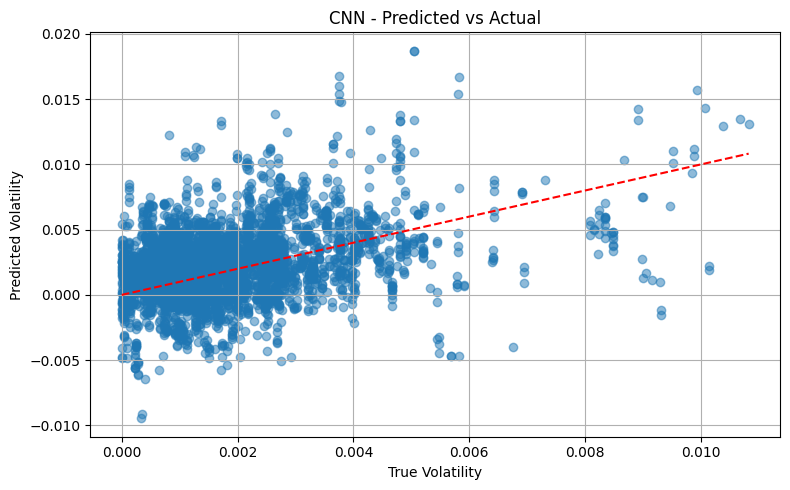

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(y_trues, y_preds, alpha=0.5)
plt.plot([y_trues.min(), y_trues.max()], [y_trues.min(), y_trues.max()], 'r--')
plt.xlabel("True Volatility")
plt.ylabel("Predicted Volatility")
plt.title("CNN - Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()
